## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [176]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [485]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

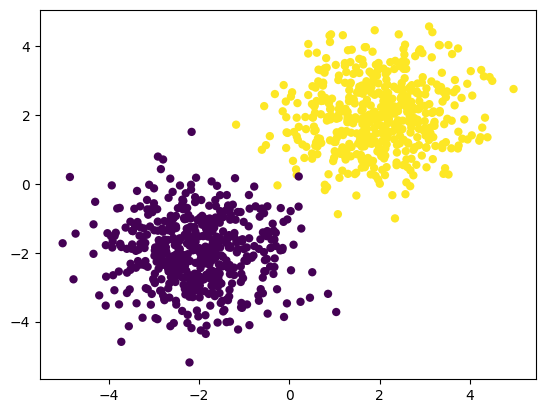

In [125]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [126]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [127]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [255]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
    #print(f"n_samples = {n_samples}, batch_size = {batch_size}")
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

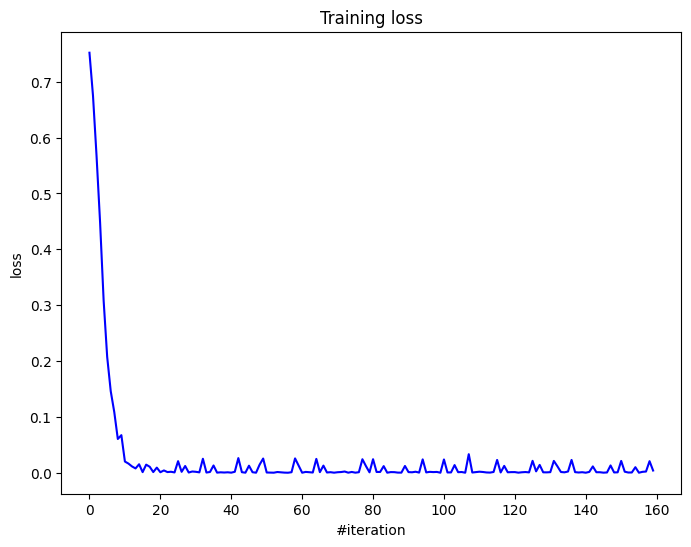

Current loss: 0.003945


In [129]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [330]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [331]:
n_classes = max(y_train)+1
n_features = np.prod(X_train[0].shape)

One-hot encode the labels first.

In [332]:
# Your code goes here. ################################################
def one_hot_encode(n_classes, y):
    y_one_hot = np.zeros((len(y), n_classes), dtype=float)
    y_one_hot[np.arange(len(y)), y.astype(int)[:]] = 1.
    return y_one_hot

def unlist_matrix(matr):
    return np.array([a.flatten() for a in matr])

y_train = one_hot_encode(n_classes, y_train)
y_test = one_hot_encode(n_classes, y_test)
X_train = unlist_matrix(X_train)
X_test = unlist_matrix(X_test)


In [333]:
n_features = X_train.shape[1]
print(n_features)

784


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [629]:
def get_loss(net, n_epoch, batch_size, momentum = "SGD"):
    # Iptimizer params
    optimizer_config ={}
    if momentum == "SGD":
        optimizer_config =  {'learning_rate' : 0.001, 'momentum': 0.9}
    else:
        optimizer_config =  {'learning_rate': 0.001 , 'beta1' : 0.9, 'beta2' : 0.999 , 'epsilon': 1e-8}
    optimizer_state = {}

    # Looping params
    loss_history = []

    for i in range(n_epoch):
        print(f"epoch number = {i}")
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            
            net.zeroGradParameters()
            
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
        
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            
            # Update weights
            if momentum == "SGD":
                sgd_momentum(net.getParameters(), 
                            net.getGradParameters(), 
                            optimizer_config,
                            optimizer_state)      
            else:
                adam_optimizer(net.getParameters(), 
                            net.getGradParameters(), 
                            optimizer_config,
                            optimizer_state)
            loss_history.append(loss)
    return loss_history


In [479]:
def plot_two(no_batch, batch, labels_names):
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    plt.yscale('log')    
    plt.title("Training loss with batch normalization and without")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    line_legend = ["RELu", "ELU", "leaky RELu", "SoftPlus"]
    no_batch_plot = plt.plot(no_batch, 'b')
    batch_plot = plt.plot(batch, 'r')
    plt.legend([no_batch_plot, batch_plot],     # The line objects
            labels=labels_names,   # The labels for each line
        #     loc="center right",   # Position of legend
        #    borderaxespad=0.1,    # Small spacing around legend box
            title="Legend Title"  # Title for the legend
            )
    plt.show()

## ReLU
### No batch normalization

In [630]:
# Your code goes here. ################################################
net = Sequential()
net.add(Linear(n_features, 25))
net.add(ReLU())
net.add(Linear(25, n_classes))
net.add(LogSoftMax())
loss_history_relu = get_loss(net, n_epoch=1, batch_size = 200)

epoch number = 0


### With batch noralization

In [631]:
# Your code goes here. ################################################
net = Sequential()
net.train()
net.add(Linear(n_features, 25))
net.add(BatchNormalization())
net.add(ReLU())
net.add(Linear(25, n_classes))
net.add(LogSoftMax())
loss_history_relu_batch = get_loss(net, n_epoch=1, batch_size = 200)

epoch number = 0


### Plotting together

C:\Users\user\AppData\Local\Temp\ipykernel_2920\392022556.py:11: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([no_batch_plot, batch_plot],     # The line objects


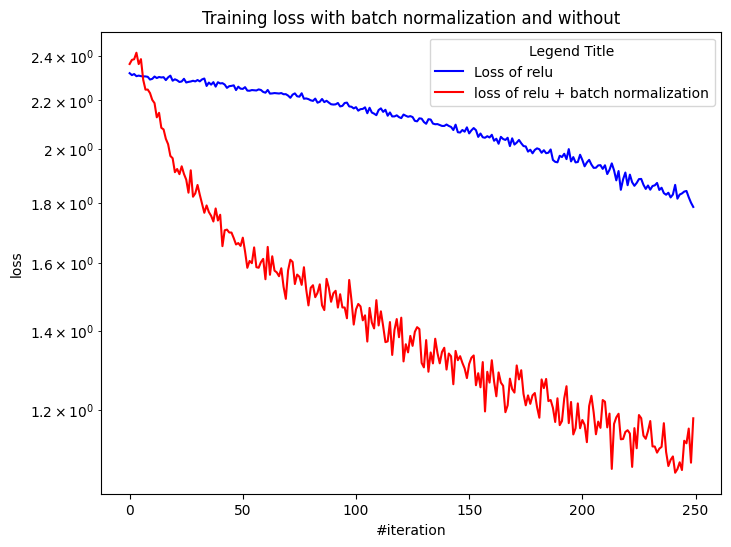

In [632]:
plot_two(loss_history_relu, loss_history_relu_batch, ["Loss of relu", "loss of relu + batch normalization"])

## ELU
### Without batch normalization

In [633]:
net = Sequential()
net.add(Linear(n_features, 25))
net.add(ELU())
net.add(Linear(25, n_classes))
net.add(LogSoftMax())
loss_history_elu = get_loss(net, n_epoch=1, batch_size = 200)

epoch number = 0


### With batch normalization

In [634]:
net = Sequential()
net.train()
net.add(Linear(n_features, 25))
net.add(BatchNormalization())
net.add(ELU())
net.add(Linear(25, n_classes))
net.add(LogSoftMax())
loss_history_elu_batch = get_loss(net, n_epoch=1, batch_size = 200)

epoch number = 0


### Plot together

C:\Users\user\AppData\Local\Temp\ipykernel_2920\392022556.py:11: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([no_batch_plot, batch_plot],     # The line objects


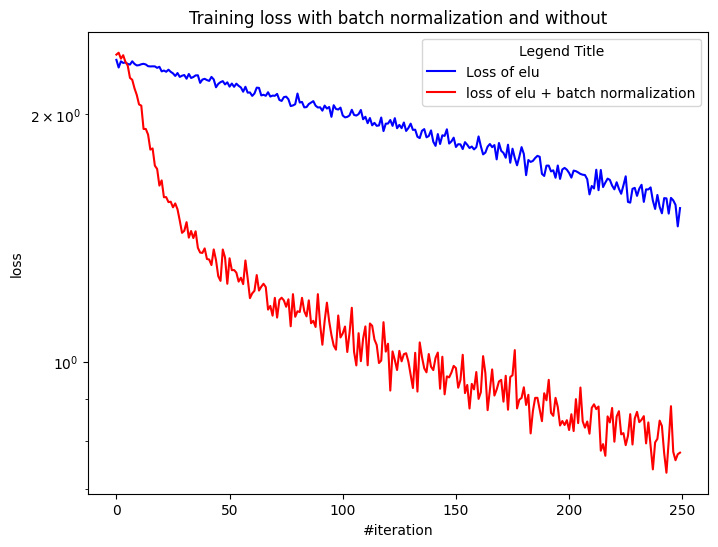

In [635]:
plot_two(loss_history_elu, loss_history_elu_batch, ["Loss of elu", "loss of elu + batch normalization"])

## Leaky ReLu
### Without batch normalization

In [636]:
net = Sequential()
net.add(Linear(n_features, 25))
net.add(LeakyReLU())
net.add(Linear(25, n_classes))
net.add(LogSoftMax())
loss_history_leaky_relu = get_loss(net, n_epoch=1, batch_size = 200)

epoch number = 0


### With batch normalization

In [637]:
net = Sequential()
net.train()
net.add(Linear(n_features, 25))
net.add(BatchNormalization())
net.add(LeakyReLU())
net.add(Linear(25, n_classes))
net.add(LogSoftMax())
loss_history_leaky_relu_batch = get_loss(net, n_epoch=1, batch_size = 200)

epoch number = 0


### Plot together

C:\Users\user\AppData\Local\Temp\ipykernel_2920\392022556.py:11: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([no_batch_plot, batch_plot],     # The line objects


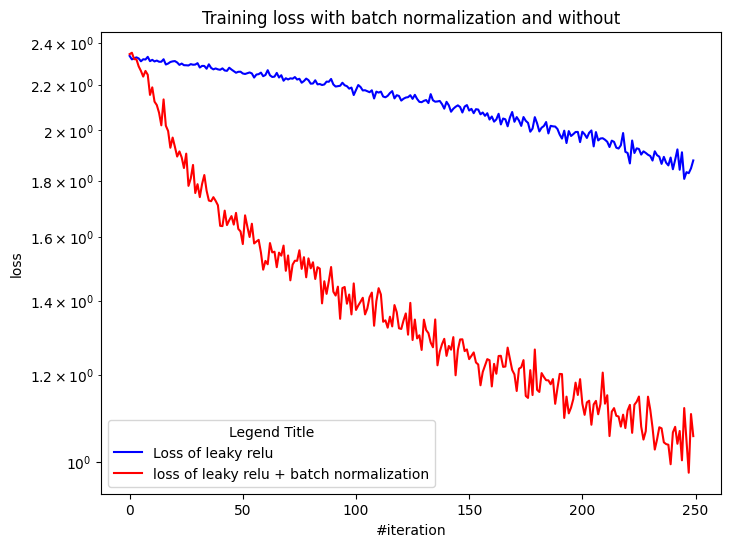

In [638]:
plot_two(loss_history_leaky_relu, loss_history_leaky_relu_batch, ["Loss of leaky relu", "loss of leaky relu + batch normalization"])

## SoftPlus
###  Without batch normalization

In [639]:
net = Sequential()
net.add(Linear(n_features, 25))
net.add(SoftPlus())
net.add(Linear(25, n_classes))
net.add(LogSoftMax())
loss_history_softplus= get_loss(net, n_epoch=1, batch_size = 200)

epoch number = 0


### With batch normalization

In [640]:
net = Sequential()
net.train()
net.add(Linear(n_features, 25))
net.add(BatchNormalization())
net.add(SoftPlus())
net.add(Linear(25, n_classes))
net.add(LogSoftMax())
loss_history_softplus_batch= get_loss(net, n_epoch=1, batch_size = 200)

epoch number = 0


### Plot together

C:\Users\user\AppData\Local\Temp\ipykernel_2920\392022556.py:11: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([no_batch_plot, batch_plot],     # The line objects


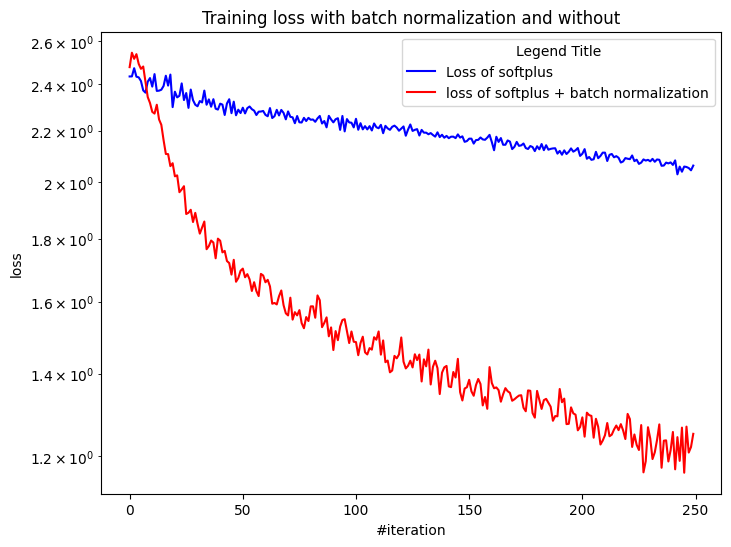

In [641]:
plot_two(loss_history_softplus, loss_history_softplus_batch, ["Loss of softplus", "loss of softplus + batch normalization"])

the most distingusible difference over all

C:\Users\user\AppData\Local\Temp\ipykernel_2920\3768330716.py:13: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([relu_plot, elu_plot, leaky_relu_plot, softplus_plot],     # The line objects


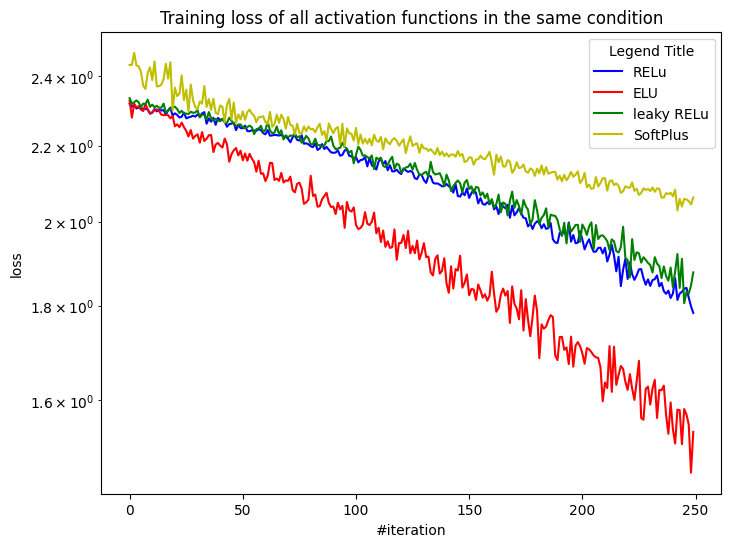

Current loss: 0.340005


In [642]:

# Visualize
display.clear_output(wait=True)
plt.figure(figsize=(8, 6))
plt.yscale('log')    
plt.title("Training loss of all activation functions in the same condition")
plt.xlabel("#iteration")
plt.ylabel("loss")
line_legend = ["RELu", "ELU", "leaky RELu", "SoftPlus"]
relu_plot = plt.plot(loss_history_relu, 'b')
elu_plot = plt.plot(loss_history_elu, 'r')
leaky_relu_plot = plt.plot(loss_history_leaky_relu, 'g')
softplus_plot = plt.plot(loss_history_softplus, 'y')
plt.legend([relu_plot, elu_plot, leaky_relu_plot, softplus_plot],     # The line objects
           labels=line_legend,   # The labels for each line
      #     loc="center right",   # Position of legend
       #    borderaxespad=0.1,    # Small spacing around legend box
           title="Legend Title"  # Title for the legend
           )
plt.show()

print('Current loss: %f' % loss_history[-1])  

Plotted all of the functions in the same conditions, ELU looks like training the fastest compared to others but it might overfit at the same time faster than others should be careful with that.  ReLu and leaky Relu looks pretty similar. Softplus looks like it has the most smooth loss decrease.

## Comparing SGD and ADAM
### SGD NN

In [643]:
# Your code goes here. ################################################
net = Sequential()
net.add(Linear(n_features, 25))
net.add(ReLU())
net.add(Linear(25, n_classes))
net.add(LogSoftMax())
loss_history_relu = get_loss(net, n_epoch=1, batch_size = 200)

epoch number = 0


### ADAM NN

In [644]:
# Your code goes here. ################################################
net = Sequential()
net.add(Linear(n_features, 25))
net.add(ReLU())
net.add(Linear(25, n_classes))
net.add(LogSoftMax())
loss_history_relu_adam = get_loss(net, n_epoch=1, batch_size = 200, momentum="ADAM")

epoch number = 0


### Plot together

C:\Users\user\AppData\Local\Temp\ipykernel_2920\392022556.py:11: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([no_batch_plot, batch_plot],     # The line objects


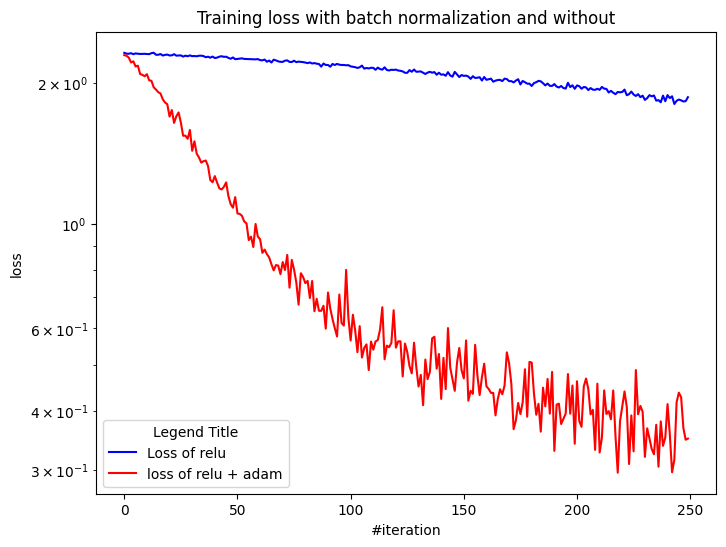

In [645]:
plot_two(loss_history_relu, loss_history_relu_adam, ["Loss of relu", "loss of relu + adam"])

In [646]:
print(f" current_loss of relu = {loss_history_relu[-1]}, current_loss of relu + adam ={loss_history_relu_adam[-1]}")

 current_loss of relu = 1.8610515291290033, current_loss of relu + adam =0.34955012819167003


Wow the loss of relu + adam is much faster optimizing than just usual sgd, such good optimization

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [ ]:
# Your answer goes here. ################################################
my examples  show the great difference between methods in the same conditions.
I believe that indeed batch normalization is performing  better result it is coming to the best model loss faster and looks more stable than
non-normalization variant

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

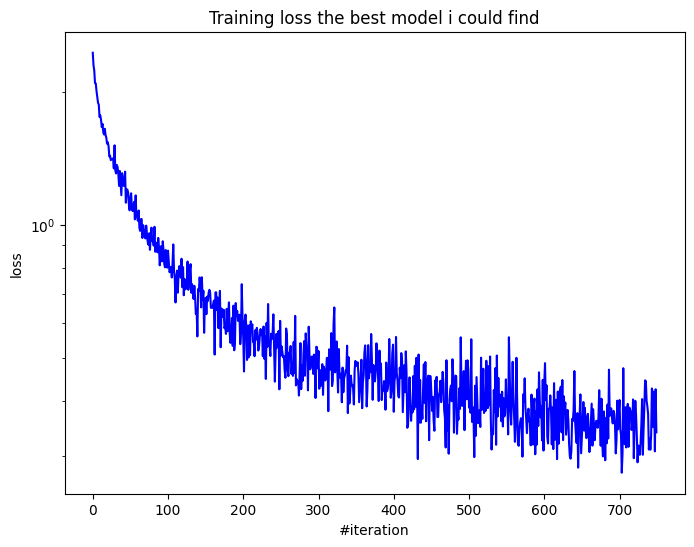

Current loss: 0.340005


In [627]:
# Your code goes here. ################################################
# Your code goes here. ################################################
net = Sequential()
net.train()
net.add(Dropout(p=0.5))
net.add(Linear(n_features, 50))
net.add(BatchNormalization())
net.add(ReLU())
net.add(Linear(50,n_classes))
net.add(LogSoftMax())
loss_history = get_loss(net, n_epoch=3, batch_size = 200, momentum="ADAM")

# Visualize
display.clear_output(wait=True)
plt.figure(figsize=(8, 6))
plt.yscale('log')    
plt.title("Training loss the best model i could find")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, 'b')
plt.show()

print('Current loss: %f' % loss_history[-1])


Print here your accuracy on test set. It should be around 90%.

In [628]:
# Your answer goes here. ################################################
from sklearn.metrics import accuracy_score

net.evaluate()
predictions = net.forward(X_test)
predictions = np.argmax(np.exp(predictions), axis = 1)
accuracy_score(one_hot_encode(n_classes, predictions), y_test)

0.9368

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [666]:
# Your "beautiful" code here.
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torch import nn
from torch.nn import functional as F

device =  torch.device("cpu")

In [679]:
model = nn.Sequential(
    nn.Dropout(p = 0.5),
    nn.Linear(n_features, 50),
    #nn.BatchNorm1d(num_features = 50, momentum = 0., eps = 1e-3), ## batchnorm is calculated differently cause of torch.var different calculation
    nn.ReLU(),
    nn.Linear(50, n_classes)
)
model.to(device, torch.float32)
opt = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
loss_func = nn.CrossEntropyLoss()#nn.NLLLoss()

In [680]:

optimizer_state = {}
model.train(True)
# Looping params
loss_history = []
n_epoch = 3
batch_size = 200
for i in range(n_epoch):
    print(f"epoch number = {i}")
    for X_batch, Y_batch in get_batches((X_train, y_train), batch_size):

        x_batch =  torch.from_numpy(X_batch)
        y_batch =  torch.from_numpy(Y_batch)
        x_batch.to(device)
        y_batch.to(device)

       
        predictions = model(x_batch)
        loss = loss_func(predictions, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()

        loss_history.append(loss.item())

epoch number = 0
epoch number = 1
epoch number = 2


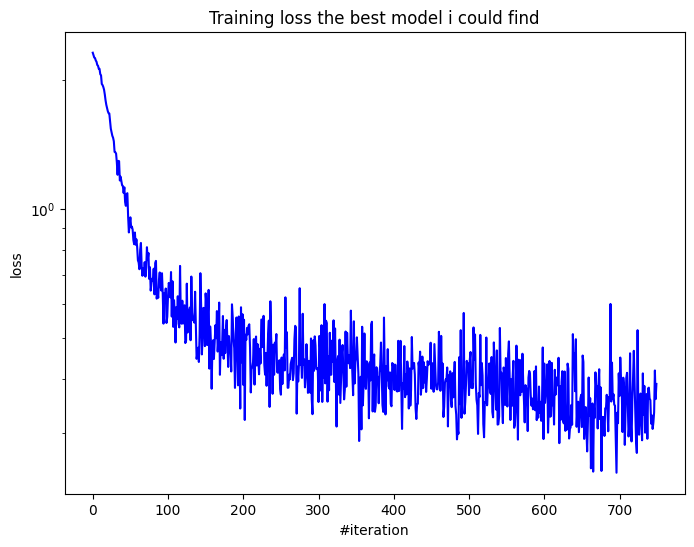

Current loss: 0.390094


In [681]:
# Visualize
display.clear_output(wait=True)
plt.figure(figsize=(8, 6))
plt.yscale('log')    
plt.title("Training loss the best model i could find")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, 'b')
plt.show()

print('Current loss: %f' % loss_history[-1])

In [682]:
# Your answer goes here. ################################################
from sklearn.metrics import accuracy_score
with torch.no_grad():
    model.eval()
    predictions = model(torch.from_numpy(X_test)).numpy()
    predictions = np.argmax(np.exp(predictions), axis = 1)
    print(accuracy_score(one_hot_encode(n_classes, predictions), y_test))

0.9334
